## import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Part a (MLP model with output layer dimension of 128, 32 and 10)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

## Load MNIST dataset


In [ ]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 105272288.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28256518.27it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27644325.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11043784.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Define the default hyperparameters

In [ ]:
default_batch_size = 16
default_num_epochs = 10
default_learning_rate = 0.001

## Define data loaders and initialization

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=default_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=default_batch_size, shuffle=False)

best_accuracy = 0
best_hyperparams = {}

## print one image and image size

Image size: torch.Size([16, 1, 28, 28])


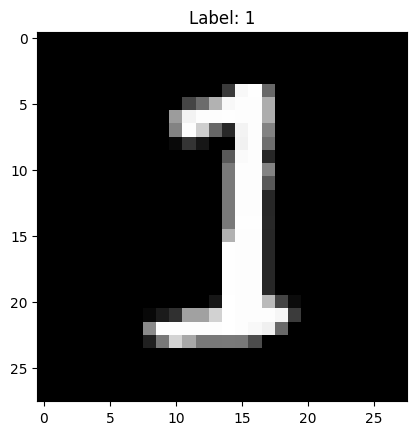

In [ ]:
import matplotlib.pyplot as plt
for images, labels in train_loader:
    print("Image size:", images.size())
    plt.imshow(images[13].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[13].item()}")
    plt.show()
    break

## specified combinations required in part a

In [ ]:

specified_combinations = []

# When changing batch size
for batch_size in [8, 16, 32]:
    specified_combinations.append((batch_size, default_num_epochs, default_learning_rate))

# When changing num epochs
for num_epochs in [1, 5, 10, 20]:
    specified_combinations.append((default_batch_size, num_epochs, default_learning_rate))

# When changing learning rate
for learning_rate in [0.0001, 0.001, 0.01]:
    specified_combinations.append((default_batch_size, default_num_epochs, learning_rate))


In [ ]:
specified_combinations

[(8, 10, 0.001),
 (16, 10, 0.001),
 (32, 10, 0.001),
 (16, 1, 0.001),
 (16, 5, 0.001),
 (16, 10, 0.001),
 (16, 20, 0.001),
 (16, 10, 0.0001),
 (16, 10, 0.001),
 (16, 10, 0.01)]

## Training and Evaluation (Part a) and save model

In [ ]:
for batch_size, num_epochs, learning_rate in specified_combinations:
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the MLP model
    model = MLP()

    #Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_hyperparams = {'batch_size': batch_size, 'num_epochs': num_epochs, 'learning_rate': learning_rate}
    print(f"Batch Size: {batch_size}, Num Epochs: {num_epochs}, Learning Rate: {learning_rate}, Accuracy: {accuracy}")
    torch.save(model.state_dict(), "best_mlp_model.pt")

Batch Size: 8, Num Epochs: 10, Learning Rate: 0.001, Accuracy: 0.9518
Batch Size: 16, Num Epochs: 10, Learning Rate: 0.001, Accuracy: 0.9582
Batch Size: 32, Num Epochs: 10, Learning Rate: 0.001, Accuracy: 0.9507
Batch Size: 16, Num Epochs: 1, Learning Rate: 0.001, Accuracy: 0.9155
Batch Size: 16, Num Epochs: 5, Learning Rate: 0.001, Accuracy: 0.9522
Batch Size: 16, Num Epochs: 10, Learning Rate: 0.001, Accuracy: 0.9565
Batch Size: 16, Num Epochs: 20, Learning Rate: 0.001, Accuracy: 0.9528
Batch Size: 16, Num Epochs: 10, Learning Rate: 0.0001, Accuracy: 0.8672
Batch Size: 16, Num Epochs: 10, Learning Rate: 0.001, Accuracy: 0.954
Batch Size: 16, Num Epochs: 10, Learning Rate: 0.01, Accuracy: 0.6683


## Best performing hperparameter

In [ ]:
print("Best performing hyperparameters:", best_hyperparams)
print(f"Best accuracy: {best_accuracy*100:0.2f}%" )

Best performing hyperparameters: {'batch_size': 16, 'num_epochs': 10, 'learning_rate': 0.001}
Best accuracy: 95.82%


## Part b(focusing on improving the existing accuracy using CNN)

In [ ]:
batch_size = best_hyperparams['batch_size'];
batch_size


16

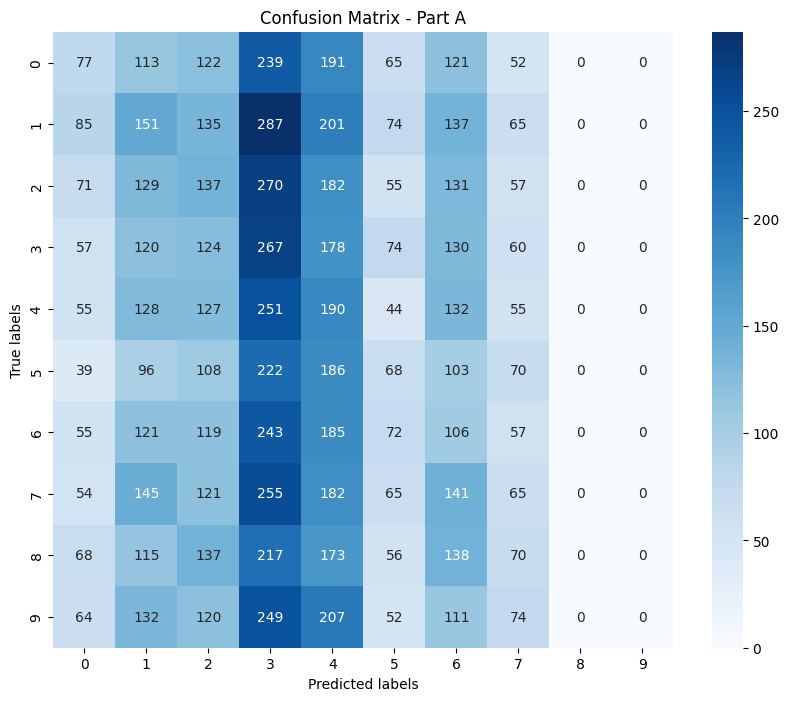

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
#Load the best MLP model
model_a = MLP()
model_a.load_state_dict(torch.load("best_mlp_model.pt"))

#Evaluate the model on the test dataset
model_a.eval()
predictions_a = []
labels_a = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_a(images)
        , predicted = torch.max(outputs, 1)
        predictions_a.extend(predicted.tolist())
        labels_a.extend(labels.tolist())


#Generate and plot confusion matrix
cm_a = confusion_matrix(labels_a, predictions_a)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_a, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Part A')
plt.show()


## train and test loader

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## CNN MLP model

In [ ]:
class CNN_MLP(nn.Module):
    def __init__(self, num_filters, filter_size):
        super(CNN_MLP, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=filter_size, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.mlp = MLP()  # Integrating MLP model from part a

        if filter_size == (2, 2):
            self.fc1 = nn.Linear(num_filters * 13 * 13, 128)
        elif filter_size == (3, 3):
            self.fc1 = nn.Linear(num_filters * 13 * 13, 128)
        elif filter_size == (4, 4):
            self.fc1 = nn.Linear(num_filters * 12 * 12, 128)

        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Reshape the tensor to match the input size of the fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


##  MLP model loaded from part a

In [ ]:
mlp_model = MLP()
mlp_model.load_state_dict(torch.load("best_mlp_model.pt"))

<All keys matched successfully>

In [ ]:
best_hyperparams

{'batch_size': 16, 'num_epochs': 10, 'learning_rate': 0.001}

## Hyperparameters

In [ ]:
# Configurations for convolutional layers
conv_configs = [(1, (2, 2)), (10, (3, 3)), (10, (4, 4))]

## variable initialization

In [ ]:
best_accuracy_b = 0.0
best_configuration = None

In [ ]:
for num_filters, filter_size in conv_configs:
  print(num_filters, filter_size)

1 (2, 2)
10 (3, 3)
10 (4, 4)


## train and evaluate(part b)

In [ ]:
#Iterate over each configuration
for num_filters, filter_size in conv_configs:
    # Initialize the CNN-MLP model
    model = CNN_MLP(num_filters, filter_size)    # Copy weights from MLP model in part a to the corresponding layers of CNN-MLP model
    model.mlp.fc1.load_state_dict(mlp_model.fc1.state_dict())
    model.mlp.fc2.load_state_dict(mlp_model.fc2.state_dict())
    model.mlp.fc3.load_state_dict(mlp_model.fc3.state_dict())    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])    # Training loop
    for epoch in range(best_hyperparams['num_epochs']):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    # Evaluation
    model.eval()
    correct = 0
    total = 0
    predictions_b = []
    labels_b = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions_b.extend(predicted.tolist())
            labels_b.extend(labels.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy_b = correct / total
    print(f"Convolutional Layer Configuration: Filters={num_filters}, Filter Size={filter_size}, Accuracy: {accuracy_b}")
    if accuracy_b > best_accuracy_b:
        best_accuracy_b = accuracy_b
        best_configuration = (num_filters, filter_size)



Convolutional Layer Configuration: Filters=1, Filter Size=(2, 2), Accuracy: 0.9523
Convolutional Layer Configuration: Filters=10, Filter Size=(3, 3), Accuracy: 0.9863
Convolutional Layer Configuration: Filters=10, Filter Size=(4, 4), Accuracy: 0.988


## Best combination

In [ ]:
print(f"Best Combination in Part B: Filters={best_configuration[0]}, Filter Size={best_configuration[1]}, Accuracy: {best_accuracy_b *100}%")

Best Combination in Part B: Filters=10, Filter Size=(4, 4), Accuracy: 98.8%


Accuracy for Part B: 0.988


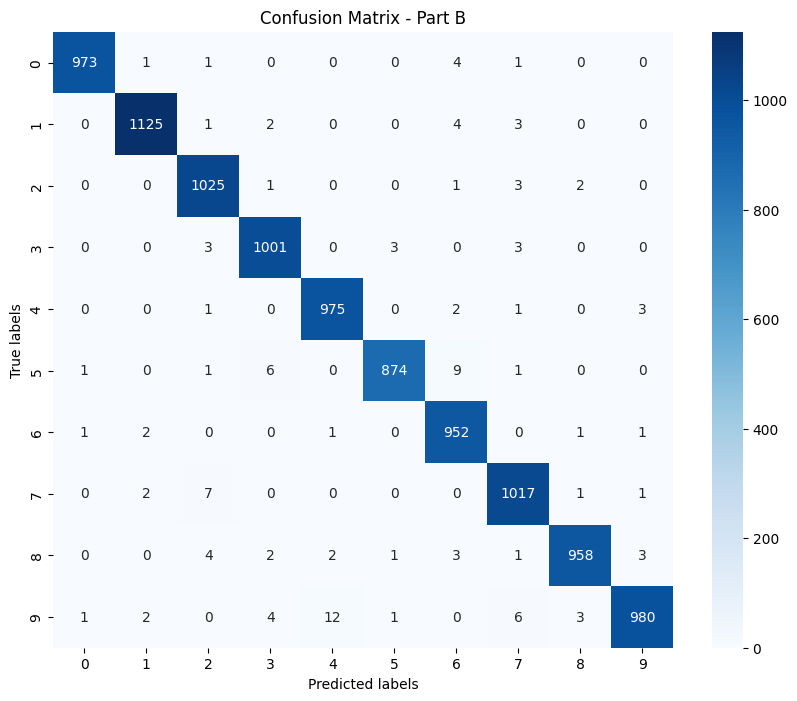

In [ ]:
cm_b = confusion_matrix(labels_b, predictions_b)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Part B')
plt.show()

## Part c (CNN MLP model)

In [ ]:
# CNN_MLP class for part c
class CNN_MLP_C(nn.Module):
    def __init__(self, num_filters1, num_filters2, filter_size):
        super(CNN_MLP_C, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters1, kernel_size=filter_size, stride=1)
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size=filter_size, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.mlp = MLP()  # Integrating MLP model from part a

        if filter_size == (2, 2):
            self.fc1 = nn.Linear(num_filters2 * 6 * 6, 128)
        elif filter_size == (3, 3):
            self.fc1 = nn.Linear(num_filters2 * 6 * 6, 128)
        elif filter_size == (4, 4):
            self.fc1 = nn.Linear(num_filters2 * 5 * 5, 128)

        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Hyperparameter and variable initialization

In [ ]:
# Initialize best accuracy and configuration for part c
best_accuracy_c = 0.0
best_configuration_c = None

# Configurations for part c
conv_configs_c = [(10, 10, (2, 2))]

In [ ]:
# Iterate over each configuration for part c
for num_filters1, num_filters2, filter_size in conv_configs_c:
    # Initialize the CNN-MLP model for part c
    model_c = CNN_MLP_C(num_filters1, num_filters2, filter_size)

    # Copy weights from MLP model in part a to the corresponding layers of CNN-MLP model in part c
    model_c.mlp.fc1.load_state_dict(mlp_model.fc1.state_dict())
    model_c.mlp.fc2.load_state_dict(mlp_model.fc2.state_dict())
    model_c.mlp.fc3.load_state_dict(mlp_model.fc3.state_dict())

    # Loss function and optimizer
    criterion_c = nn.CrossEntropyLoss()
    optimizer_c = optim.Adam(model_c.parameters(), lr=best_hyperparams['learning_rate'])

    # Training loop for part c
    for epoch in range(best_hyperparams['num_epochs']):
        model_c.train()
        for images, labels in train_loader:  # Using the same data loader from part b
            optimizer_c.zero_grad()
            outputs_c = model_c(images)
            loss_c = criterion_c(outputs_c, labels)
            loss_c.backward()
            optimizer_c.step()

    # Evaluation for part c
    model_c.eval()
    correct_c = 0
    total_c = 0
    predictions_c = []
    labels_c = []
    with torch.no_grad():
        for images, labels in test_loader:  # Using the same data loader from part b
            outputs_c = model_c(images)
            _, predicted_c = torch.max(outputs_c.data, 1)
            predictions_c.extend(predicted_c.tolist())
            labels_c.extend(labels.tolist())
            total_c += labels.size(0)
            correct_c += (predicted_c == labels).sum().item()

    accuracy_c = correct_c / total_c
    print(f"Convolutional Layer Configuration for part c: Filters1={num_filters1}, Filters2={num_filters2}, Filter Size={filter_size}, Accuracy: {accuracy_c}")

    if accuracy_c > best_accuracy_c:
        best_accuracy_c = accuracy_c
        best_configuration_c = (num_filters1, num_filters2, filter_size)

Convolutional Layer Configuration for part c: Filters1=10, Filters2=10, Filter Size=(2, 2), Accuracy: 0.9856


In [ ]:
best_accuracy_c

0.9856

In [ ]:
print(f"Best accuracy for part c: {best_accuracy_c * 100:.2f}%")
print(f"Best configuration for part c: {best_configuration_c}")

Best accuracy for part c: 98.56%
Best configuration for part c: (10, 10, (2, 2))


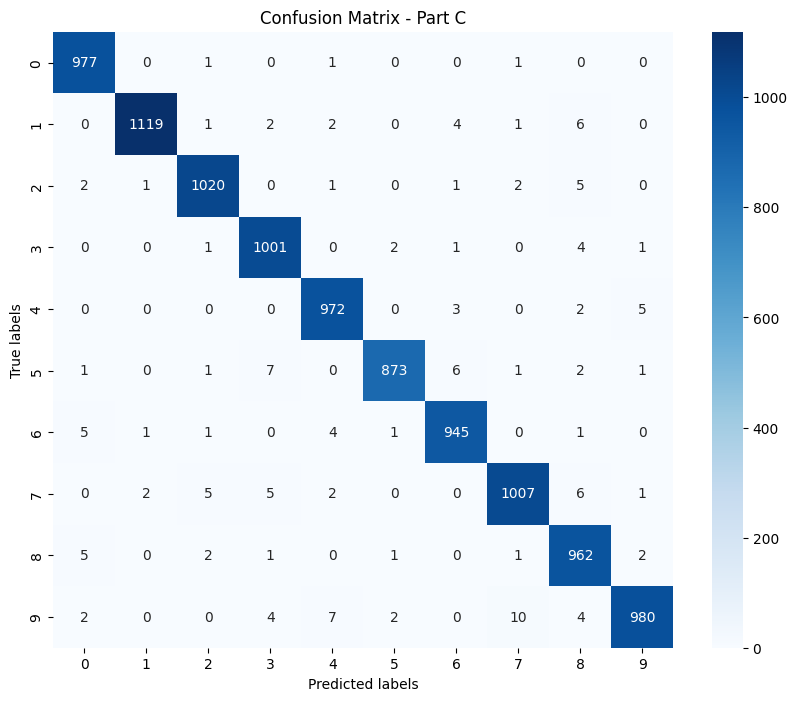

In [ ]:
# Generate and plot confusion matrix
cm_c = confusion_matrix(labels_c, predictions_c)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_c, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Part C')
plt.show()